<a href="https://colab.research.google.com/github/navneetslovely/QML_genom/blob/main/VQC_Z_obj_func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
!pip install qiskit-machine-learning
!pip install qiskit[visualization]
!pip install genomic-benchmarks
!pip install tensorflow>=2.6.0
!pip install tensorflow-addons
!pip install typing-extensions --upgrade
!pip install qiskit-aer

Mounted at /content/drive
/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.5 MB/s eta 0:00:00
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512616 sha256=c1009debecaabf82e67de165658f9ca6f41ebd5115e26

In [2]:
from pathlib import Path
import os
import sys
import tensorflow as tf
import warnings
import numpy as np
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from genomic_benchmarks.loc2seq import download_dataset
from genomic_benchmarks.data_check import is_downloaded, info
from genomic_benchmarks.models.tf import vectorize_layer
from genomic_benchmarks.models.tf import get_basic_cnn_model_v0 as get_model
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from functools import partial
# from qiskit import Aer
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.primitives import Sampler
import pickle
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import PegasosQSVC
import json
import time
import warnings
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
import pandas as pd
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.decomposition import PCA
algorithm_globals.random_seed = 42

In [3]:

# Load the preprocessed data
train_sequences = np.load('train_sequences.npy')
# print('train_sequences',train_sequences[:2])
train_labels = np.load('train_labels.npy')
# print('train_labels',train_labels[:2])
test_sequences = np.load('test_sequences.npy')
# print('test_sequences',test_sequences[:2])
test_labels = np.load('test_labels.npy')
# print('test_labels',test_labels[:2])
# Perform PCA transformation on the data
pca = PCA(n_components=4)
train_sequences = pca.fit_transform(train_sequences)
test_sequences= pca.fit_transform(test_sequences)
train_sequences = train_sequences[:20000]
train_labels = train_labels[:20000]

In [4]:
# Define the feature dimension or number of qubits
feature_dim = len(train_sequences[0])
print("Feature dimension and number of qubits:", feature_dim)

Feature dimension and number of qubits: 4


In [5]:
from qiskit.circuit.library import ZFeatureMap

feature_dim = len(train_sequences[0])
prep = ZFeatureMap(feature_dim, reps=2)
ansatz = RealAmplitudes(num_qubits=feature_dim, reps=2)


In [6]:
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [7]:
def parity(x):
    return "{:b}".format(x).count("1") % 2
output_shape = 2

In [8]:
optimizer = COBYLA(maxiter=100)
vqc = VQC(
        feature_map=prep,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=Sampler(),
        callback=callback_graph
)

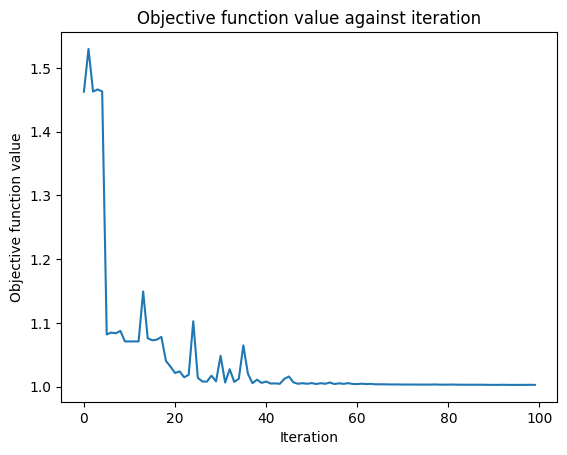

In [9]:
total_time = 0
start_time = time.time()
vqc.fit(train_sequences, train_labels)
end_time = time.time()
epoch_time = end_time - start_time
total_time += epoch_time

In [10]:
print(f"Total training time: {total_time:.2f} seconds")

Total training time: 5450.20 seconds


In [11]:
df_test = pd.DataFrame(objective_func_vals)
df_test.to_csv('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/obj_fun_val_VQC_Z.csv', index=False)
data = pd.read_csv('/content/drive/MyDrive/Quantum_Studies_phd/PhD/QML_Genom/obj_fun_val_VQC_Z.csv')
print(data.head())

          0
0  1.462764
1  1.529798
2  1.462923
3  1.466252
4  1.463109


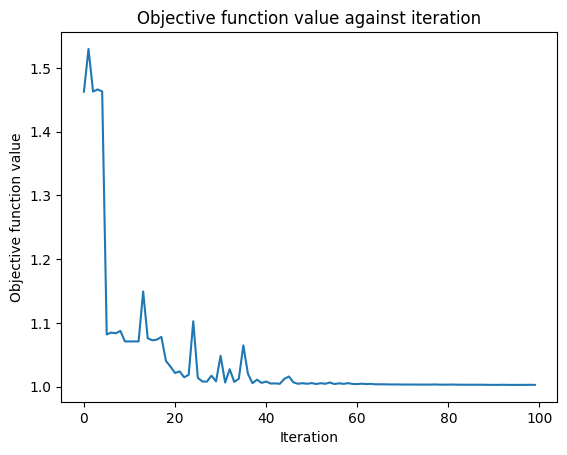

In [12]:
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(data)), data)
plt.show()